<center><h1>Value-Based Reinformance Learning</h1></center>

# Deep Q-Learning (DQN)

DQN uses a neural network to approximate the Q-values. The loss function such as the MSE loss can be:
$$ L = \left(Q(s, a;\theta) - (r + \gamma \max_{a'} Q(s', a';\theta')) \right) ^ 2$$

The update rule depends on the values produced by the network itself, making convergence diffucult. To address this, the DQN algorithm introduces the use of a replay buffer and target networks. The replay buffer stores past interactions as a list of tuples, which can be sampled to update the value and policy networks. This allows the network to learn from individual tuples multiple times and reduces dependence on the current experience. The target networks are time-delayed copies of the policy and Q-networks, and their parameters are updated according to the following equations:

$$ \theta_Q' \leftarrow \tau \theta_Q + (1 - \tau) \theta_Q'$$
$$ \theta_\mu' \leftarrow \tau \theta_\mu + (1 - \tau) \theta_\mu'$$

where $\theta_\mu'$ and $\theta_Q'$ denote the parameters of the policy and Q-networks, respectively.

<center>
    <img src="./images/dqn.webp" alt="example">
</center>

# Double Deep Q-Learning (Double DQN)

$$ Q(s,a;\theta) = r + \gamma Q(s', argmax_{a'} Q(s', a'; \theta); \theta')$$
The main neural network, $\theta$ determines the best next action $a'$, while the target network is used to evaluate this action and compute its Q-value. This simple change has been shown to reduce overestimations of Q-values in DQN.

# Dueling Deep Q-Learning
$$ Q(s,a) = V(s) + (A(s, a) - \frac{1}{|A|} \sum_{a'} A(s, a'))$$

# Code Example

In [1]:
import torch
import torch.nn as nn
import numpy as np
import gymnasium as gym
from implementation.model import DQN, Dueling_DQN
from implementation.util import *
import random

In [2]:
class DQNAgent(object):
    def __init__(self, env_name:str, type:str, batch_size:int=MINI_BATCH_SIZE):
        self.env = gym.make(env_name)
        self.type = type
        self.in_features = int(np.prod(self.env.observation_space.shape))
        self.num_actions = self.env.action_space.n

        if self.type == 'Dueling_DQN':
            self.online_net = Dueling_DQN(self.in_features, self.num_actions)
            self.target_net = Dueling_DQN(self.in_features, self.num_actions)
        else:
            self.online_net = DQN(self.in_features, self.num_actions)
            self.target_net = DQN(self.in_features, self.num_actions)

        self.optimizer = torch.optim.Adam(self.online_net.parameters(), lr=5e-4)
        self.loss_fn = nn.functional.smooth_l1_loss
        self.memory = ReplayMemory(batch_size=batch_size)
        self.epsilon_gen = self.epsilon_generator(EPSILON_START, EPSILON_END, EPSILON_DECAY)

    def create_replay_buffer(self, replay: int):
        state, info = self.env.reset()
        for _ in range(replay):
            action = self.env.action_space.sample()
            next_state, reward, terminated, truncated, info = self.env.step(action)
            memory = (state, action, reward, terminated, next_state)
            self.memory.add(memory)
            state = next_state

            if terminated:
                state, info = self.env.reset()
    
    def epsilon_generator(self, start, end, decay):
        step = 0
        while True:
            epsilon = np.interp(step, [0, decay], [start, end])
            yield epsilon
            step += 1
    
    def train(self, steps, gamma):
        self.create_replay_buffer(MIN_REPLAY_SIZE)
        rewards = []
        # Get initial state
        episode = 0
        episode_reward = 0
        state, info = self.env.reset()

        for i in range(steps):
            # Choose action
            epsilon = next(self.epsilon_gen)
            action = (
                self.env.action_space.sample()
                if random.random() <= epsilon
                else self.online_net.act(state)
            )

            # Act
            next_state, reward, terminated, _, _ = self.env.step(action)
            self.memory.add((state, action, reward, terminated, next_state))
            state = next_state
            episode_reward += reward

            # Start new episode
            if terminated:
                state, info = self.env.reset()
                rewards.append(episode_reward)
                if episode % 10 == 0:
                    print(f"Episode: {episode}, Reward: {episode_reward}")
                episode += 1
                episode_reward = 0
                
            
            # Train
            state_batch, action_batch, reward_batch, terminal_batch, next_state_batch = self.memory.sample()
            
            ## Compute Targets
            if self.type == "Double_DQN":
                target_q_inner = self.online_net(next_state_batch)
                target_a = torch.argmax(target_q_inner, dim=1, keepdim=True)
                target_q_values = self.target_net(next_state_batch)
                target_a_q_values = torch.gather(input=target_q_values, dim=1, index=target_a)
                targets = reward_batch + gamma * (1 - terminal_batch) * target_a_q_values
            else:
                target_q_values = self.target_net(next_state_batch)  # [batch, 2]
                max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]  # [batch, 1]
                targets = reward_batch + gamma * (1 - terminal_batch) * max_target_q_values
            
            ## Compute Loss
            q_values = self.online_net(state_batch)
            a_q_values = torch.gather(input=q_values, dim=1, index=action_batch)
            loss = self.loss_fn(a_q_values, targets)
            
            ## Gradient Descent
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            
            # Update Target Network
            if i % TARGET_UPDATE_FREQUENCY == 0:
                self.target_net.load_state_dict(self.online_net.state_dict())
            
        return rewards

/home/gyc/rl-with-example/venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


Episode: 0, Reward: 29.0
Episode: 10, Reward: 37.0
Episode: 20, Reward: 12.0
Episode: 30, Reward: 11.0


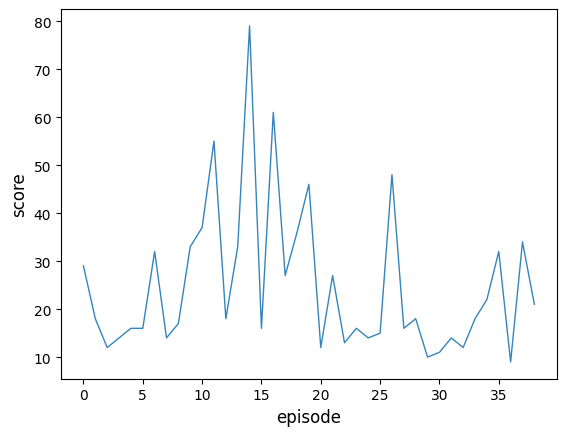

In [3]:
def main():   
    agent = DQNAgent('CartPole-v0', 'Dueling_DQN', batch_size=MINI_BATCH_SIZE)
    rewards = agent.train(steps=1000, gamma=0.99)
    plot_graph(rewards)

main()